In [1]:
import gurobipy as gp
from gurobipy import *
import geopy.distance

In [2]:

import numpy as np
from numpy import loadtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
from heapq import nsmallest

In [3]:
df_csv = pd.read_csv('C:/Users/USER/OneDrive/Work TBSI/Graduate/Paper/Data set/Data_1/150_Low.csv')

df_csv[['Index','demand','prob_fail','fixed cost','lat','lon']].head()

,Index,demand,prob_fail,fixed cost,lat,lon
0,0,732.2564,0.001,100000,40.67054,73.94548
1,1,348.5398,0.004,100000,34.11210,118.41120
2,2,278.3726,0.023,100000,41.83705,87.68497
3,3,163.0553,0.002,100000,29.76805,95.38733
4,4,158.5577,0.020,100000,40.00682,75.13468


In [4]:
def lat_lon_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = geopy.distance.distance(result[i], result[j]).km*0.621371
    return dist
def euc_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = math.sqrt( (result[i][0]- result[j][0])**2 + (result[i][1]- result[j][1])**2)
    return dist
    
length = df_csv.shape[0]
c_ij = lat_lon_distmatrix(df_csv)*(10**(-5))
#c_ij = euc_distmatrix(df_csv)*(10**(-3))
c_ij[:,length] = c_ij[:,length]+0.1  #Emergency cost

In [5]:
V_1 = [i for i in range(0, length)] # Customer
V_2 = [i for i in range(0, length+1)] # Facility + emergency
S = [i for i in range(0, 10)] #Scenarios
T = [i for i in range(1, 5)] #Time 4 period 
TE = [i for i in range(0, 5)] # include period 0

d_i = list(df_csv['demand']*10000)

f_j = list(df_csv['fixed cost']) 

A = [(i, j, t, s) for i in V_1 for j in V_2 for t in T for s in S ]
A_1 = [(i, j, t, s) for i in V_1 for j in V_2[:-1] for t in T for s in S ]

E = [(i, j) for i in V_1 for j in V_2 ]


o = 3000
c = 3000
jt = [(j, t) for j in V_2 for t in T]

q_jt = np.zeros((len(V_1)+1,4))
info = [1,2,4,8]
for i in range(0,4):
    q_jt[:,i] = list(df_csv['prob_fail'] *(info[i])) + [0] #Prob_fail + Emergency facility
    # (i+1)*0.25


for i in V_1:
    #if i not in idx_fix:      
    f_j[i] =  f_j[i]/10

# Scenarios generate

In [8]:
# 49  [0, 2, 4, 7, 21, 29]


# 150 nodes data set
#idx_x = [0,1,2,7,34,37,136]# from set risk 0

# 88 nodes data set
#idx_x = [3,4,6,16,29,32,45,58,66]# from set risk 0
#From 88 data set 
idx_x = [0,1,2,7,34,37,136]

X = np.zeros(len(V_1))
for i in idx_x:
    X[i] = 1.0
print(X)

[1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [49]:
def rank_risk(V_1 ,q_jt, N = 20, t = 3): # Number of decision var.
    idx = list(np.argsort(q_jt[:,t])[:N])
    return idx  
  
idx_set = rank_risk(V_1 ,q_jt, N = 2, t = 1)
###################################################################
idx_set = list(set(idx_x).union(set(idx_set))) #include initial
idx_set.sort(reverse=1)

In [50]:
print(np.array(idx_set)[1:].shape) 
np.array(idx_set)[1:] #cut 88

(8,)


array([136, 121,  37,  34,   7,   2,   1,   0], dtype=int64)

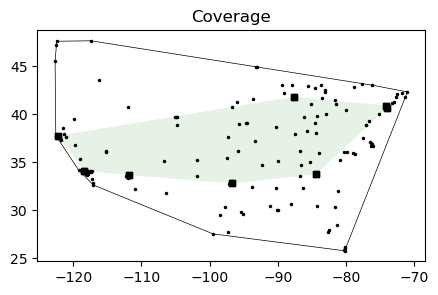

Percent coverage: 80.0246210823978%
Total union set: [136, 121, 37, 34, 7, 2, 1, 0]
8


In [51]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

###Generate point for plot###
#points = np.array(list(zip(df_csv['lon'], df_csv['lat'])))  # Random points in 2-D
points = []
for i in idx_set[1:]: #no cutting , cut 88
    points.append([ list(df_csv['lon'])[i]*(-1) , list(df_csv['lat'])[i] ])
points = np.array(points)

full_points = np.array(list(zip(list(df_csv['lon']*(-1)), list(df_csv['lat']))))
#############################


hull = ConvexHull(points)
hull_full = ConvexHull(full_points)

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig,  ax2 = plt.subplots(ncols=1, figsize=(5, 3))

for ax in  [ax2]: ####(ax1, ax2)
    ax.plot(points[:, 0], points[:, 1], 's', color='k', ms = 5)
    ax.plot(full_points[:, 0], full_points[:, 1], '.', color='k', ms = 3)
    

    ax.set_title('Coverage')
    '''for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'g', lw = 0.5)'''
    for simplex in hull_full.simplices:
        ax.plot(full_points[simplex, 0], full_points[simplex, 1], 'k', lw = 0.5)

    ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 's', mec='k', color='none', lw=1, markersize=5)

    #Fill the area within the lines that we have drawn
    ax.fill(points[hull.vertices,0], points[hull.vertices,1], 'g', alpha=0.1)
    
plt.show()

print("Percent coverage: {}%".format(hull.area*100/hull_full.area))
total_set = idx_set[1:]
print("Total union set: {}".format(total_set))
print(len(total_set))

# Plot pareto

In [21]:
x=[]
per_cover = []
full_points = np.array(list(zip(list(df_csv['lon']), list(df_csv['lat']))))
hull_full = ConvexHull(full_points)
for i in range(0,91):#more than 3 node to calculate area
    idx_set = rank_risk(V_1 ,q_jt, N = i, t = 3)
    # Include initial
    idx_set = list(set(idx_x).union(set(idx_set))) #include initial
    idx_set.sort(reverse=1)
    
    points = []
    for i in idx_set[1:]:
        points.append([ list(df_csv['lon'])[i] , list(df_csv['lat'])[i] ])
    points = np.array(points)
    hull = ConvexHull(points)
    
    
    per_cover.append(hull.area/hull_full.area)
    x.append(points.shape[0])
per_cover = [0,0]+per_cover
x = [0,0]+x

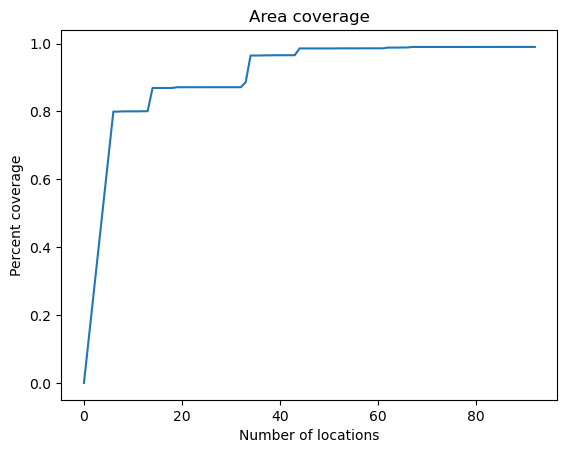

In [22]:

y = per_cover

plt.plot(x, y)
plt.title('Area coverage')
plt.xlabel('Number of locations')
plt.ylabel('Percent coverage')
plt.show()

In [23]:
dict(zip(x, y))

{0: 0,
 6: 0.7995200718077725,
 7: 0.7995207285637465,
 8: 0.8002462108239781,
 9: 0.8002462108239781,
 10: 0.8002462108239781,
 11: 0.8002751468070909,
 12: 0.8006517779483977,
 13: 0.8006517779483977,
 14: 0.869177061906264,
 15: 0.869177061906264,
 16: 0.869177061906264,
 17: 0.869177061906264,
 18: 0.869177061906264,
 19: 0.8713844298845967,
 20: 0.8713844298845967,
 21: 0.8713844298845967,
 22: 0.8713844298845967,
 23: 0.8713844298845967,
 24: 0.8713844298845967,
 25: 0.8713844298845967,
 26: 0.8713844298845967,
 27: 0.8713988165290512,
 28: 0.8713988165290512,
 29: 0.8713988165290512,
 30: 0.8713988165290512,
 31: 0.8713988165290512,
 32: 0.8713988165290512,
 33: 0.8860224163241341,
 34: 0.9648467583480519,
 35: 0.9648467583480519,
 36: 0.9648467583480519,
 37: 0.9653392428707399,
 38: 0.9653392428707399,
 39: 0.9656501990667424,
 40: 0.9656501990667424,
 41: 0.9656501990667424,
 42: 0.965686831940186,
 43: 0.965686831940186,
 44: 0.9856776160445384,
 45: 0.9856776160445384,
 46:

# 

# Figure

In [10]:
#idx_set = [29, 21, 7, 4, 2, 0]
idx_set = [29, 21, 7, 4, 2, 0]
can_set = list(range(0,49))
dist_set = []
X = np.zeros(len(V_1))
for i in idx_set:
    X[i] = 1.0


In [11]:
# Arc
df_csv = pd.read_csv('C:/Users/USER/OneDrive/Work TBSI/Graduate/Paper/Data set/Data_1/49_Low.csv')

df_csv[['Index','demand','prob_fail','fixed cost','lat','lon']].head()

def lat_lon_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = geopy.distance.distance(result[i], result[j]).km*0.621371
    return dist
length = df_csv.shape[0]
c_ij = lat_lon_distmatrix(df_csv)*(10**(-5))
c_ij[:,length] = c_ij[:,length]+0.1  #Emergency cost


V_1 = [i for i in range(0, length)] # Customer
V_2 = [i for i in range(0, length+1)] # Facility + Emergency
R = [i for i in range(0, 3)] #Backup leve
T = [i for i in range(1, 2)] #Time 4 period  (1,5)
TE = [i for i in range(0, 2)] # include period 0 (0,5)

###### Convex Hull ########

set_init = set([29, 21, 7, 4, 2, 0])

###########################


d_i = list(df_csv['demand']*10000)

f_j = list(df_csv['fixed cost']) + [0]

#A = [(i, j, r, t) for i in V_1 for j in V_2 for r in R for t in T]
A = [(i, j, r) for i in V_1 for r in R for j in V_2 ]

J = V_2[-1]
E = [(i, j) for i in V_1 for j in V_2 ]

#A_1 = [(i, j, r, t) for i in V_1 for j in V_2[:-1] for r in R[:-1] for t in T]
A_1 = [(i, j, r) for i in V_1 for r in R[:-1] for j in V_2[:-1] ]

o = 3000/1
c = 3000/1
jt = [(j, t) for j in V_2 for t in T]

## Multi period information #####################
q_jt = np.zeros((len(V_1)+1,4))
info = [1,2,4,8]
for i in range(0,4):
    q_jt[:,i] = list(df_csv['prob_fail'] *(info[i])) + [0] #Prob_fail + Emergency facility
    # (i+1)*0.25


d_it = np.zeros((len(d_i),4))
rho = 0.5 #0, 0.5, 1 
for i in range(0,4):
    d_it[:,i] = np.array(d_i)*((q_jt[:-1,i]*rho)+1) #Prob_fail + Emergency facility

    
for i in V_1:
    #if i not in idx_fix:      
    f_j[i] =  f_j[i]/10
##################################################


#info = [0.1, 0.5, 1.0, 2.5]   Result diff 2 %
#info = [0.1, 0.2, 0.8, 3.0]   Result diff 3.4 %
def setup_LRUFL(X,V_1,V_2, R):
    open_loc = [i for i in range(len(X)) if X[i]>0]
    open_loc.append(V_2[-1])
    Arc = [(i, j, r) for i in V_1 for j in open_loc for r in R ]
    E = [(i, j) for i in V_1 for j in open_loc ]
    Arc_1 = [(i, j, r) for i in V_1 for j in open_loc[:-1] for r in R[:-1]]
    
    return Arc, E, Arc_1, open_loc


def LRUFL_givenX(X, V_1, V_2, R, d_i, q_j, f_j, A, J, E, A_1):
    m = gp.Model("LRUFLX")
    m.Params.OutputFlag = 0
    
    x = X
    y = m.addVars(A, vtype=GRB.BINARY, name ="y")
    p = m.addVars(A, vtype=GRB.CONTINUOUS, name ="p")
    w = m.addVars(A, vtype=GRB.CONTINUOUS, name ="w")


    m.setObjective(quicksum(w[i, j, r]*c_ij[i, j]*d_i[i] for i,j,r in A) +  quicksum(f_j[j]*x[j] for j in V_2[:-1]),
                   GRB.MINIMIZE)

    # Constraint 1b
    m.addConstrs( quicksum(y[i, j, r] for j in V_2[:-1]) + quicksum(y[i, J, s] for s in range(r+1))  == 1 
                 for i in V_1 for r in R)

    # Constraint 1c
    m.addConstrs( quicksum(y[i, j, r] for r in R[:-1])  <= x[j]
                 for i in V_1 for j in V_2[:-1] )

    # Constraint 1d
    m.addConstrs( quicksum(y[i, J, r] for r in R)  == 1
                 for i in V_1 )

    # Constraint 1e
    m.addConstrs( p[i, j, 0]  == 1-q_j[j]
                 for i in V_1 for j in V_2 )

    # Constraint 1f (revise)
    m.addConstrs( p[i, j, r]  == (1-q_j[j])*quicksum(q_j[k]*w[i, k, r-1]/(1-q_j[k]) for k in V_2[:-1])
                 for i in V_1 for j in V_2 for r in R[1:] )

    # Constraint 2a
    m.addConstrs( w[i, j, r]  <= p[i, j, r]
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2b
    m.addConstrs( w[i, j, r]  <= y[i, j, r]
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2c
    m.addConstrs( w[i, j, r]  >= 0
                 for i in V_1 for j in V_2 for r in R)
    # Constraint 2d
    m.addConstrs( w[i, j, r]  >= p[i, j, r]+y[i, j, r]-1
                 for i in V_1 for j in V_2 for r in R)

    m.optimize()

    Var_cost = m.ObjVal - np.dot(f_j[:-1], x)
    
    Y_sol = {}
    W_sol = {}
    for i,j,r in A:
        if y[(i,j,r)].x >= 0.5:
            Y_sol[i,j,r] = 1
            W_sol[i,j,r] = w[(i,j,r)].x
    
    return m.ObjVal, Var_cost , Y_sol, W_sol

In [12]:
t =0
Total_cost, Var_cost , Y_sol, W_sol = LRUFL_givenX(X, V_1, V_2, R, d_i, q_jt[:,t], f_j, A, J, E, A_1)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-29


In [13]:
active_arcs2 = list(Y_sol.keys())

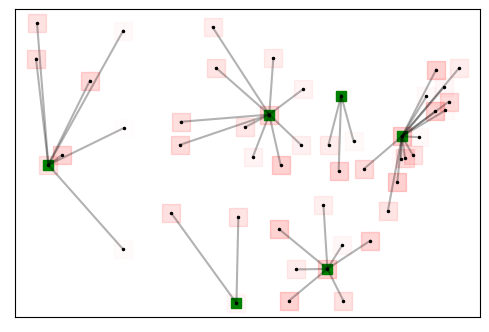

In [17]:
###Generate point for plot###
#points = np.array(list(zip(df_csv['lon'], df_csv['lat'])))  # Random points in 2-D
points = []
for i in idx_set[0:]: #no cutting , cut 88
    points.append([ list(df_csv['lon'])[i]*(-1) , list(df_csv['lat'])[i] ])
points = np.array(points)

can_points = []
for i in can_set: #no cutting , cut 88
    can_points.append([ list(df_csv['lon'])[i]*(-1) , list(df_csv['lat'])[i] ])
can_points = np.array(can_points)

dis_points = []
for i in dist_set: #no cutting , cut 88
    dis_points.append([ list(df_csv['lon'])[i]*(-1) , list(df_csv['lat'])[i] ])
dis_points = np.array(dis_points)

full_points = np.array(list(zip(list(df_csv['lon']*(-1)), list(df_csv['lat']))))
#############################

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig,  ax2 = plt.subplots(ncols=1, figsize=(6, 4))

for ax in  [ax2]: ####(ax1, ax2)
    ax.plot(points[:, 0], points[:, 1], 's', color='green', ms = 7)
    ax.plot(full_points[:, 0], full_points[:, 1], '.', color='k', ms = 3)
    #ax.scatter(can_points[:, 0], can_points[:, 1], marker = 's', color='white', linewidths =1, edgecolor ="green", s = 50)
    #ax.scatter(dis_points[:, 0], dis_points[:, 1], marker = 's', color='red', linewidths =1, edgecolor ="red", s = 50)
    
#Plot risk
for i in range(49):
    ax.scatter(can_points[i, 0], can_points[i, 1], marker = 's', color='red',  s = 150, alpha = q_jt[i,3])
    

for i, j, r in active_arcs2:
    if r == 0:
        ax.plot([df_csv['lon'][i]*(-1), df_csv['lon'][j]*(-1)], [df_csv['lat'][i], df_csv['lat'][j]], c='k', alpha=0.3)
    '''
    if r == 1:
        ax.plot([df_csv['lon'][i]*(-1), df_csv['lon'][j]*(-1)], [df_csv['lat'][i], df_csv['lat'][j]], c='green', alpha=0.1)
'''
        
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()


In [178]:
q_jt[:,3]

array([0.224, 0.192, 0.28 , 0.208, 0.312, 0.36 , 0.088, 0.392, 0.232,
       0.048, 0.104, 0.4  , 0.368, 0.032, 0.024, 0.104, 0.4  , 0.368,
       0.24 , 0.336, 0.08 , 0.024, 0.28 , 0.176, 0.232, 0.088, 0.4  ,
       0.248, 0.056, 0.208, 0.072, 0.2  , 0.36 , 0.336, 0.264, 0.072,
       0.192, 0.136, 0.328, 0.112, 0.152, 0.216, 0.4  , 0.296, 0.344,
       0.008, 0.176, 0.096, 0.376, 0.   ])

In [176]:
can_points[0,0]

-121.46736

In [173]:
[ax2]

[<AxesSubplot:>]

In [50]:
can_points[:, 0]

array([ -73.799017,  -84.281399, -104.872655])

In [115]:
can_points

array([[-73.799017,  42.66575 ],
       [-84.281399,  30.457   ]])

In [114]:
points

array([[-93.617405,  41.576738],
       [-86.284287,  32.3544  ],
       [-84.553996,  42.7091  ],
       [-76.884503,  40.27605 ],
       [-97.750522,  30.30588 ]])